# Homework 5

Original source of the data: https://www.kaggle.com/dansbecker/nba-shot-logs.

It can also be downloaded from my own repository: https://github.com/khrapovs/dataanalysispython/blob/master/data/shot_logs.zip.

Note that Seaborn library (http://seaborn.pydata.org/index.html) is not a part of Anaconda. So you have to install it, for example, `conda install seaborn`.

In [1]:
import re
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('float_format', '{:6.2f}'.format)
sns.set_context('notebook')
sns.set_palette('deep')

# Ignore warnings. This is a temporary bug that should disappear in future versions of the libraries used here.
import warnings
warnings.filterwarnings("ignore")

## Q1 (5 points)

Import the data into the pandas `DataFrame` from the zip file. Show types of the variables and the first five rows of the data.

In [2]:
fname = 'shot_logs'
path = '../../data/'
zf = zipfile.ZipFile(path + fname + '.zip')
data = pd.read_csv(zf.open(fname + '.csv'), header=0)

print(data.dtypes)
print(data.head())

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object
    GAME_ID                   MATCHUP LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            1   
1  21400899  MAR 04, 2015 - 

## Q2 (10 points)

Convert string variable `GAME_CLOCK` into integer seconds `GAME_CLOCK_SEC`. Show five largest values of the resulting variable.

In [3]:
def convert_to_sec(arg):
    temp = re.search('(\d+)\:(\d+)', arg).groups()
    return int(temp[0]) * 60 + int(temp[1])

data['GAME_CLOCK_SEC'] = data['GAME_CLOCK'].map(convert_to_sec)
print(data['GAME_CLOCK_SEC'].nlargest(5))

15469    720
15548    720
67665    720
16165    717
17408    717
Name: GAME_CLOCK_SEC, dtype: int64


## Q3 (15 points)

Compute the average point increment at each second of a game. Compute the moving average of the resulting variable. Draw both on the same plot.

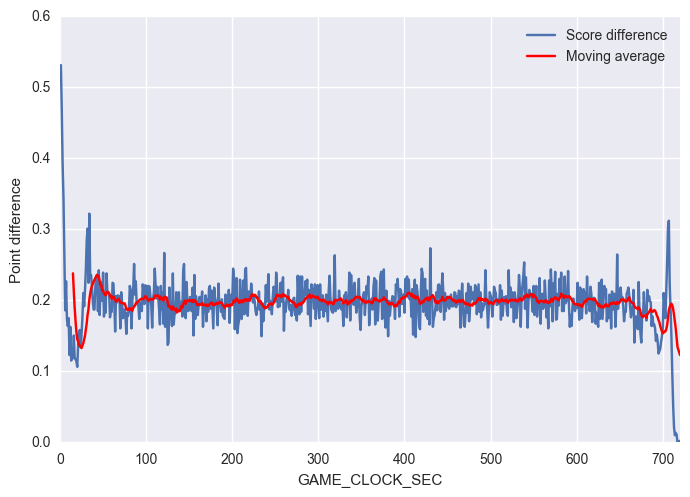

In [4]:
df = data.copy()

df = df.groupby(['GAME_ID', 'GAME_CLOCK_SEC'])[['PTS']].sum()
df['SCORE'] = df.groupby(level=['GAME_ID'])['PTS'].apply(lambda x: x.cumsum())
df = df['SCORE'].unstack('GAME_ID').fillna(method='ffill').fillna(0)
df = df.mean(1).diff()
rolling = df.rolling(window=15).mean()

df.plot(label='Score difference')
rolling.plot(color='r', label='Moving average')
plt.ylabel('Point difference')
plt.legend()
plt.show()

## Q4 (10 points)

Plot the distribution (kernel density estimate) of the shot distance for each game-player.

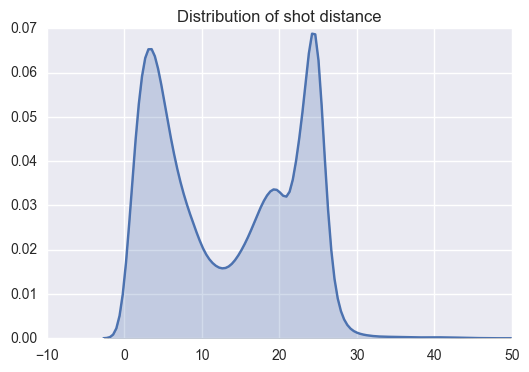

In [5]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data['SHOT_DIST'], shade=True, legend=False)
plt.title('Distribution of shot distance')
plt.show()

## Q5 (10 points)

Plot the distribution (kernel density estimate) of the shot distance for each game-player spearated by whether the shot was successeful or not.

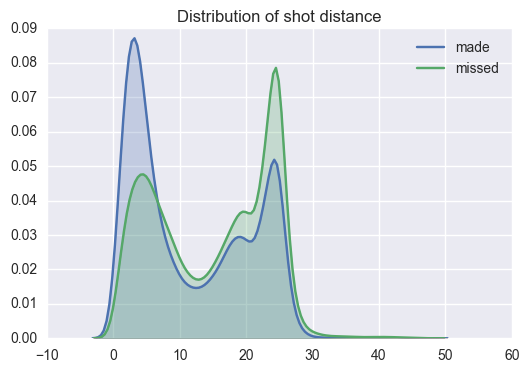

In [6]:
fig = plt.figure(figsize=(6, 4))
grouped = data.groupby('SHOT_RESULT')
for i, group in grouped:
    sns.kdeplot(group['SHOT_DIST'], shade=True, label=i)
plt.title('Distribution of shot distance')
plt.show()

## Q6 (10 points)

Compute average success ratio (number of successeful shots to the total number of shots) for each combination of player, game, location (home or away), and type of shot (2 or 3). Show first five rows of the data.

In [7]:
df = data.copy()

idx = ['GAME_ID', 'player_id', 'LOCATION', 'PTS_TYPE']
fun = {'PTS': lambda x: 100 * x[x > 0].count() / x.count(), 'SHOT_DIST': np.mean}
df = df.groupby(idx, as_index=False).agg(fun)
df.rename(columns={'PTS': 'Success ratio'}, inplace=True)

print(df.head())

    GAME_ID  player_id LOCATION  PTS_TYPE  SHOT_DIST  Success ratio
0  21400001       2732        A         2      14.25          16.67
1  21400001       2732        A         3      23.65           0.00
2  21400001     201582        H         2      12.50         100.00
3  21400001     201583        H         2       6.22          37.50
4  21400001     201583        H         3      26.35          50.00


## Q7 (5 points)

Draw scatter plot of success ratio versus shot distance together with the OLS regression line.

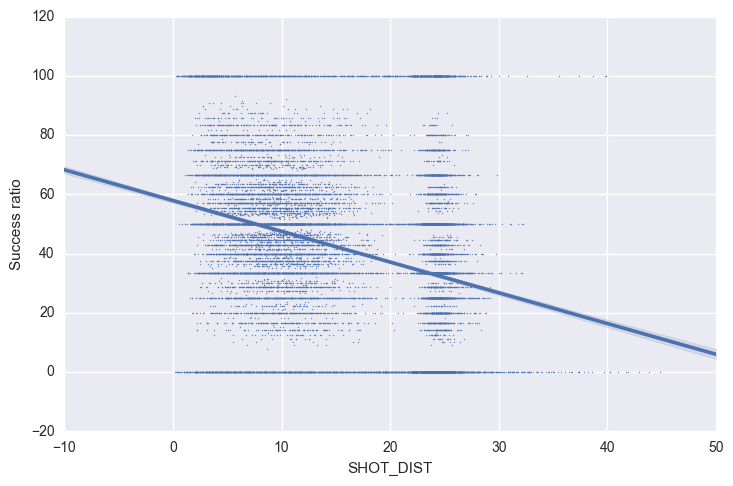

In [8]:
sns.lmplot(y='Success ratio', x='SHOT_DIST', legend_out=False,
           data=df, scatter_kws={"s": 1}, size=5, aspect=1.5)
plt.show()

## Q8 (5 points)

Draw scatter plot of success ratio versus shot distance together with the OLS regression line both separated by location of the game (home or away).

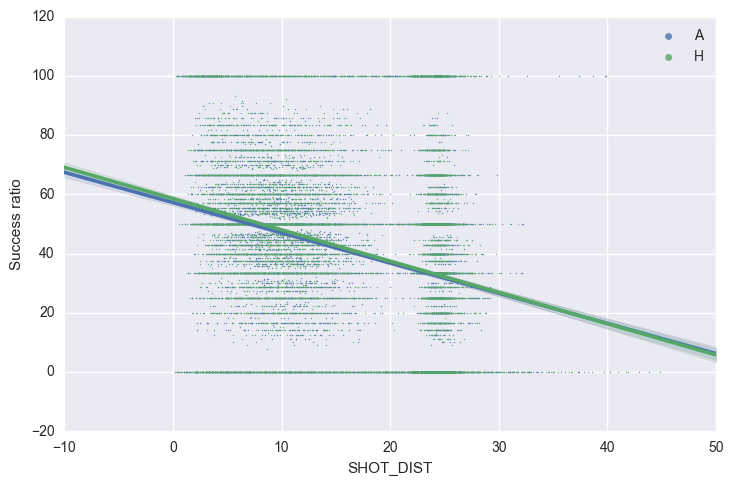

In [9]:
sns.lmplot(y='Success ratio', x='SHOT_DIST', hue='LOCATION', legend_out=False,
           data=df, scatter_kws={"s": 1}, size=5, aspect=1.5)
plt.legend(markerscale=5)
plt.show()

## Q9 (5 points)

Draw scatter plot of success ratio versus shot distance together with the OLS regression line both separated by location of the game (home or away) and shot type (2 or 3).

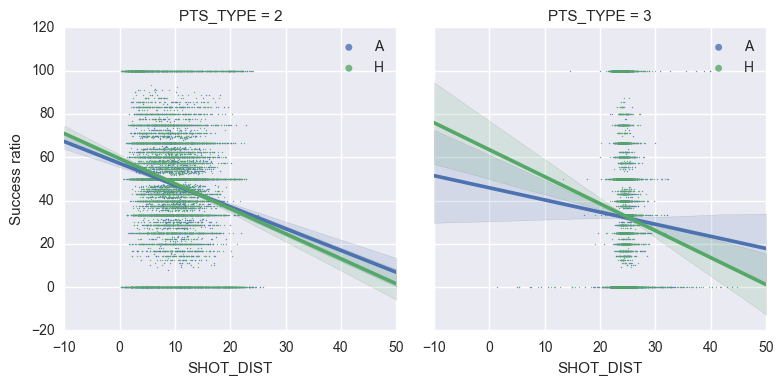

In [10]:
lmp = sns.lmplot(y='Success ratio', x='SHOT_DIST', hue='LOCATION', legend_out=False, col='PTS_TYPE',
           data=df, scatter_kws={"s": 1}, size=4, aspect=1)
lmp.axes[0, 0].legend(markerscale=5)
lmp.axes[0, 1].legend(markerscale=5)
plt.show()